In [0]:
!pip install pyshp

In [0]:
!pip install PyDrive

In [0]:
!pip install geopandas

In [0]:
!pip install rasterio

In [0]:
!pip install descartes

In [0]:
def Init_PyDrive():
  global ID_BY_NAME
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  global gauth
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  global drive
  drive = GoogleDrive(gauth)
  ID_BY_NAME = dict()
  file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
  for i in file_list:
    print(i['title'])
    ID_BY_NAME[i['title']] = i['id']

In [0]:
Init_PyDrive()

In [0]:
def Download_File(filename, savename):
  file = drive.CreateFile({'id': ID_BY_NAME[filename]})
  file.GetContentFile(savename)

In [0]:
def Upload_File(filename, drivename):
  file = drive.CreateFile({"title": drivename})
  file.SetContentFile(filename)
  file.Upload()

In [0]:
#Download_File("moscow.tif", "moscow.tif")
Download_File("moscow_autumn.tiff", "moscow_autumn.tiff")
#Download_File("newbuilding-polygon.shp", "newbuilding-polygon.shp")
#Download_File("newbuilding-polygon.dbf", "newbuilding-polygon.dbf")
#Download_File("newbuilding-polygon.shx", "newbuilding-polygon.shx")
#Download_File("newbuilding-polygon.prj", "newbuilding-polygon.prj")
#Download_File("newbuilding-polygon.qpj", "newbuilding-polygon.qpj")
Download_File("polygons4moscow.shp", "polygons4moscow.shp")
Download_File("polygons4moscow.dbf", "polygons4moscow.dbf")
Download_File("polygons4moscow.shx", "polygons4moscow.shx")
Download_File("polygons4moscow.prj", "polygons4moscow.prj")
Download_File("polygons4moscow.qpj", "polygons4moscow.qpj")

In [0]:
import operator
import numpy as np
from osgeo import gdal, gdal_array, osr, gdalnumeric, ogr
import shapefile
from PIL import Image, ImageDraw
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from descartes import PolygonPatch
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist

In [0]:
raster_path  = './moscow_autumn.tiff'
#srcArray = gdal_array.LoadFile(raster_path)
srcImage = gdal.Open(raster_path)
geoTrans = srcImage.GetGeoTransform()
shapefile_path = './polygons4moscow.shp'
shapef = shapefile.Reader("%s" % shapefile_path)

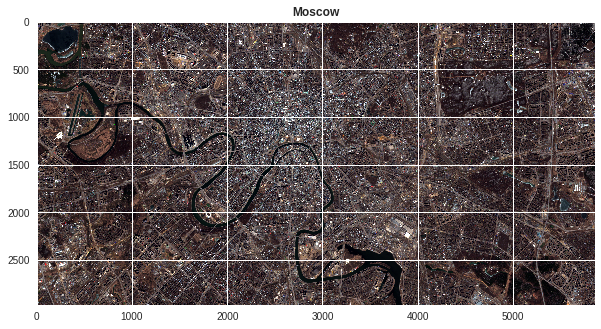

In [20]:
plt.figure(figsize=(10,10))
with rio.open(raster_path) as src:
    bb = src.read()
show(bb, title="Moscow")
plt.show()

In [21]:
len(shapef)

196494

In [22]:
geoTrans

(4164442.1798597174,
 8.89700465029,
 0.0,
 7520027.707460768,
 0.0,
 -8.89700465029)

<Figure size 1080x1080 with 0 Axes>

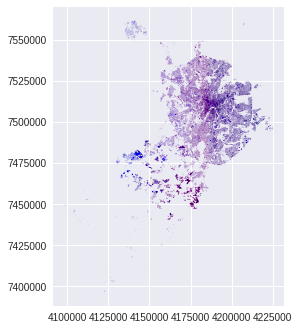

In [23]:
plt.figure(figsize=(15,15))
grid = gpd.read_file(shapefile_path)
my_map = grid.plot(linewidth=0.1, cmap="Reds", scheme="quantiles", k=11, alpha=1)
grid.plot(ax=my_map, color="blue", linewidth=2.5)
plt.show()

In [0]:
def world2Pixel(geoMatrix, x, y):
  """
  Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
  the pixel location of a geospatial coordinate 
  """
  ulX = geoMatrix[0]
  ulY = geoMatrix[3]
  xDist = geoMatrix[1]
  yDist = geoMatrix[5]
  rtnX = geoMatrix[2]
  rtnY = geoMatrix[4]
  pixel = int((x - ulX) / xDist)
  line = int((ulY - y) / xDist)
  return (pixel, line) 


In [0]:
def imageToArray(i):
    """
    Converts a Python Imaging Library array to a gdal_array image.
    """
    a = gdal_array.numpy.frombuffer(i.tobytes(), 'b')
    a.shape = i.im.size[1], i.im.size[0]
    return a

In [0]:
minX, maxX, maxY, minY = int(geoTrans[0]/geoTrans[1]), int((geoTrans[0] + srcImage.RasterXSize * geoTrans[1])/geoTrans[1]), int(geoTrans[3]/abs(geoTrans[5])), int((geoTrans[3] + srcImage.RasterYSize * geoTrans[5])/abs(geoTrans[5]))

In [0]:
pxWidth = maxX - minX
pxHeight = maxY - minY

In [28]:
print(pxWidth, pxHeight)

5859 2973


In [0]:
pixels = []
length = len(shapef)
rasterPoly = Image.new("L", (pxWidth, pxHeight), 1)
rasterize = ImageDraw.Draw(rasterPoly)
for i in range(length):
    for point in shapef.shape(i).points:
        x, y = world2Pixel(geoTrans, point[0], point[1])
        pixels.append((x, y))
    rasterize.polygon(pixels, 0)
    pixels = []

In [0]:
mask = imageToArray(rasterPoly)

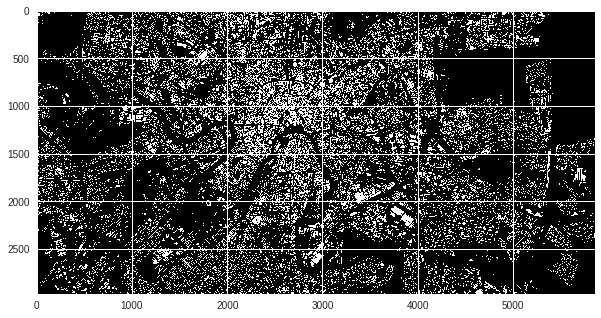

In [31]:
plt.figure(figsize=(10,10))
imshow(mask)
plt.show()

In [0]:
format = 'GTiff'
gtiffDriver = gdal.GetDriverByName(format)
output = gtiffDriver.Create("mask.tif", mask.shape[1], mask.shape[0], 1, gdal.GDT_Byte)
output.SetGeoTransform(srcImage.GetGeoTransform())
output.SetProjection(srcImage.GetProjection())
output = None

In [0]:
Upload_File('mask.tif', 'mscmask.tif')